# 1. Исследовательский анализ данных

In [1]:
# Блок импорта
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image

# Определим seed
RANDOM_STATE = 12345
#
DIR_NAME = '/datasets/faces/final_files/'

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=DIR_NAME,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=RANDOM_STATE)

labels.info()

Found 7591 validated image filenames.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


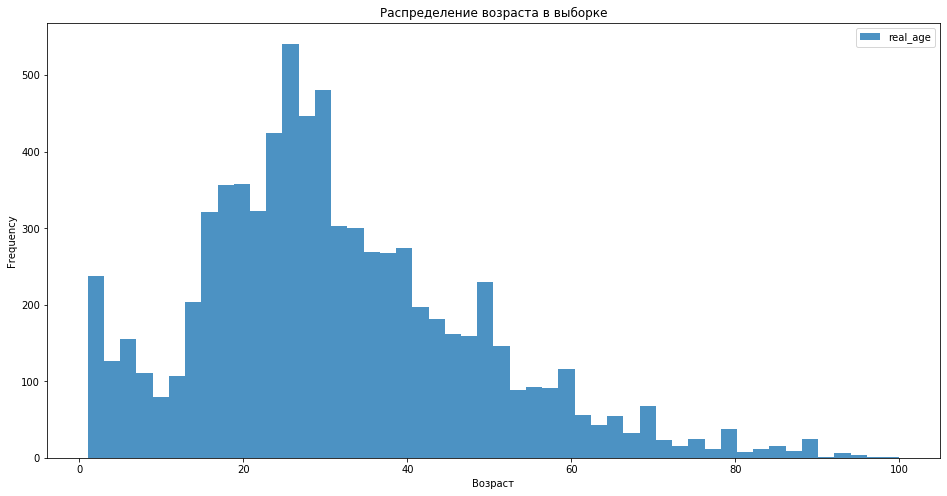

In [3]:
fig, ax = plt.subplots()
ax.set_title('Распределение возраста в выборке')
ax.set_xlabel('Возраст')
labels.plot(kind='hist', bins=50, figsize=(16,8), ax=ax, alpha=0.8)

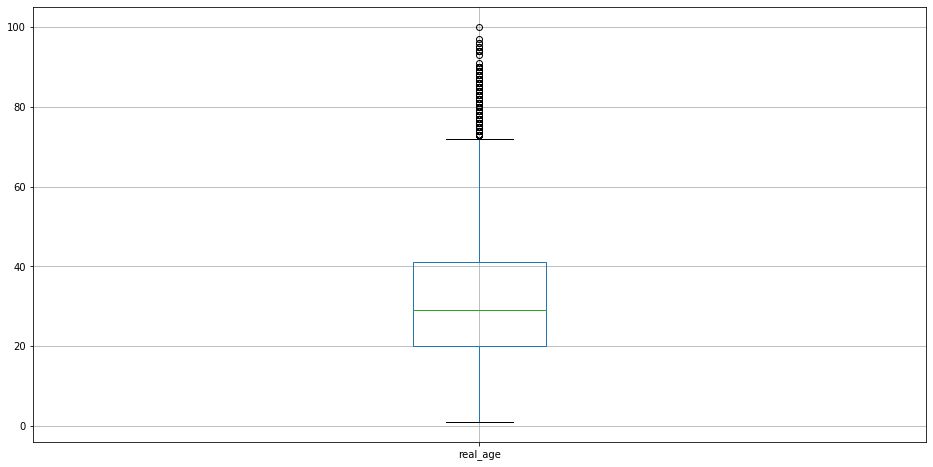

In [4]:
# Ради интереса посмотрим boxplot
labels.boxplot(column=['real_age'], figsize=(16, 8))
plt.show()

In [5]:
# Посмотрим, сколько у нас значений больше 72
labels.query('real_age > 73').groupby(by='real_age').count()

,file_name
real_age,
74,6
75,17
76,7
77,8
78,3
79,6
80,31
81,3
82,5


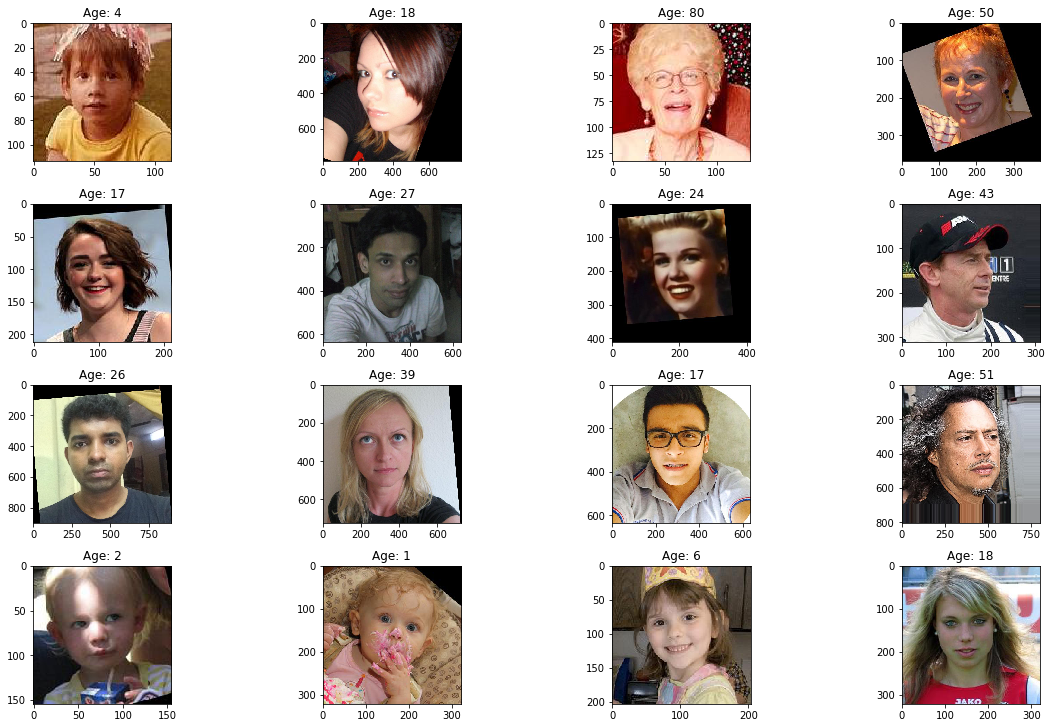

In [6]:
# Посмотрим на фотографии

shape = (4, 4)
fig, ax = plt.subplots(*shape, figsize=(16, 10), constrained_layout=True)    

for column_number, column in enumerate(ax):
    for row_number, row in enumerate(column):
        image_loc = column_number * shape[1] + row_number
        data = labels.iloc[image_loc]
        fname = DIR_NAME + data['file_name']
        row.imshow(Image.open(fname))
        row.set_title('Age: ' + str(data['real_age']))

plt.show()

### Промежуточный вывод

- Вопрос не столько в выбросах, столько в том, что где у нас мало примеров, мы вряд ли сможем определить возраст и выделить необходимые признаки. Пока оставим как есть, хотя, скорее всего, в будущем, я бы использовал другой датасет или исключил единичные значения
- Датасет кривоват. Помимо того, что ряд фотографий повернуты (по хорошему, сперва выровнять их), лица не всегда смотрят в одном направлении. На втором фото второго ряда явно проблемы с тенями, могут быть проблемы с определением лица, в то же время на третьем фото первого ряда явный пересвет. По хорошему тут нужно несколько этапов предварительной обработки, чтобы более качественно определять возраст. Само лицо на изображениях может занимать разную площать (хотя тут, можно считать их сопоставимыми). Также на 4м фото в третьем ряду есть артефакты, скорее всего будут проблемы с определением. А детские фотографии кроме лица содержать дополнительные элементы, что также могут нам помешать.

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=12345)
		
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
	
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
			  
    return model

```

```

2021-01-10 09:29:00.406325: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2021-01-10 09:29:01.152136: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2021-01-10 09:29:18.171384: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-01-10 09:29:18.846123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-01-10 09:29:18.846235: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-01-10 09:29:18.846273: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-01-10 09:29:19.131287: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-01-10 09:29:19.233077: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-01-10 09:29:20.401999: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-01-10 09:29:20.504901: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-01-10 09:29:20.505012: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-01-10 09:29:20.508454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-01-10 09:29:20.508915: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-01-10 09:29:20.724637: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2021-01-10 09:29:20.728222: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x47c3530 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-01-10 09:29:20.728253: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-01-10 09:29:21.152343: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3ec6cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-01-10 09:29:21.152383: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2021-01-10 09:29:21.154346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-01-10 09:29:21.154413: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-01-10 09:29:21.154427: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-01-10 09:29:21.154450: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-01-10 09:29:21.154464: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-01-10 09:29:21.154476: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-01-10 09:29:21.154503: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-01-10 09:29:21.154513: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-01-10 09:29:21.157968: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-01-10 09:29:21.174158: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-01-10 09:29:28.628556: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-01-10 09:29:28.628621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2021-01-10 09:29:28.628629: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2021-01-10 09:29:28.639969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2021-01-10 09:30:13.452308: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-01-10 09:30:17.618726: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 117s - loss: 202.2819 - mae: 10.5522 - val_loss: 296.5832 - val_mae: 12.8486
Epoch 2/10
178/178 - 38s - loss: 100.5549 - mae: 7.6459 - val_loss: 319.9664 - val_mae: 13.2390
Epoch 3/10
178/178 - 38s - loss: 66.1105 - mae: 6.2110 - val_loss: 327.4150 - val_mae: 13.4502
Epoch 4/10
178/178 - 37s - loss: 43.0875 - mae: 5.0174 - val_loss: 182.0859 - val_mae: 10.1794
Epoch 5/10
178/178 - 38s - loss: 32.4612 - mae: 4.3521 - val_loss: 106.4432 - val_mae: 7.7733
Epoch 6/10
178/178 - 38s - loss: 23.8520 - mae: 3.7690 - val_loss: 81.7306 - val_mae: 6.8601
Epoch 7/10
178/178 - 37s - loss: 16.5419 - mae: 3.1425 - val_loss: 74.3592 - val_mae: 6.4810
Epoch 8/10
178/178 - 38s - loss: 11.4293 - mae: 2.5890 - val_loss: 78.0634 - val_mae: 6.5959
Epoch 9/10
178/178 - 38s - loss: 9.8892 - mae: 2.3927 - val_loss: 72.4196 - val_mae: 6.4100
Epoch 10/10
178/178 - 37s - loss: 8.4995 - mae: 2.2299 - val_loss: 71.5443 - val_mae: 6.3595
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 71.5443 - mae: 6.3595
Test MAE: 6.3595

```

# 3. Анализ обученной модели

Честно говоря, я несколько удивлен, т.к. для достижения необходимой метрики не понадобилась допаолнительная предобработка (повороты, распознавание лиц, удаление кривых данных, попытка выжать максимум из того, что есть), т.к. нельзя сказать, что сам датасет был данными мечты.
Да и само решение максимально простое (в сравнении с предлагаемыми в статье)

Тем не менее, полученная модель позволяет решать задачи бизнеса в базовом виде.